# Set up
## Check Environment

In [2]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [3]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [4]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [5]:
%%capture 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from tqdm import tqdm  
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud

In [6]:
## Get Data from S3 Bucket

In [7]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/data"
s3_public_path_1="s3://sagemaker-studio-458903497716-h2kl4ff3dz/census_2010_data"
s3_public_path_2="s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_abbrev_data"
s3_public_path_3="s3://sagemaker-studio-458903497716-h2kl4ff3dz/congress_data"
s3_public_path_4="s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_income_data"
s3_public_path_5="s3://sagemaker-studio-458903497716-h2kl4ff3dz/cities_data"

In [8]:
%store s3_public_path
%store s3_public_path_1
%store s3_public_path_2
%store s3_public_path_3
%store s3_public_path_4
%store s3_public_path_5

Stored 's3_public_path' (str)
Stored 's3_public_path_1' (str)
Stored 's3_public_path_2' (str)
Stored 's3_public_path_3' (str)
Stored 's3_public_path_4' (str)
Stored 's3_public_path_5' (str)


In [9]:
s3_private_path = "s3://{}/gun_violence_data".format(bucket)
s3_private_path_1 = "s3://{}/census2010_data".format(bucket)
s3_private_path_2 = "s3://{}/state_abbrev_data".format(bucket)
s3_private_path_3= "s3://{}/congress_data".format(bucket)
s3_private_path_4= "s3://{}/state_income_data".format(bucket)
s3_private_path_5= "s3://{}/cities_data".format(bucket)

print(s3_private_path)
print(s3_private_path_1)
print(s3_private_path_2)
print(s3_private_path_3)
print(s3_private_path_4)
print(s3_private_path_5)

s3://sagemaker-us-east-1-458903497716/gun_violence_data
s3://sagemaker-us-east-1-458903497716/census2010_data
s3://sagemaker-us-east-1-458903497716/state_abbrev_data
s3://sagemaker-us-east-1-458903497716/congress_data
s3://sagemaker-us-east-1-458903497716/state_income_data
s3://sagemaker-us-east-1-458903497716/cities_data


In [10]:
%store s3_private_path
%store s3_private_path_1
%store s3_private_path_2
%store s3_private_path_3
%store s3_private_path_4
%store s3_private_path_5

Stored 's3_private_path' (str)
Stored 's3_private_path_1' (str)
Stored 's3_private_path_2' (str)
Stored 's3_private_path_3' (str)
Stored 's3_private_path_4' (str)
Stored 's3_private_path_5' (str)


In [11]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --include "*" 
!aws s3 cp --recursive $s3_public_path_1/ $s3_private_path_1/ --include "*"
!aws s3 cp --recursive $s3_public_path_2/ $s3_private_path_2/ --include "*" 
!aws s3 cp --recursive $s3_public_path_3/ $s3_private_path_3/ --include "*" 
!aws s3 cp --recursive $s3_public_path_4/ $s3_private_path_4/ --include "*" 
!aws s3 cp --recursive $s3_public_path_5/ $s3_private_path_5/ --include "*" 

copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv to s3://sagemaker-us-east-1-458903497716/gun_violence_data/gun_violence.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/census_2010_data/sub_est2018_all.csv to s3://sagemaker-us-east-1-458903497716/census2010_data/sub_est2018_all.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_abbrev_data/state_abbrev_map.csv to s3://sagemaker-us-east-1-458903497716/state_abbrev_data/state_abbrev_map.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/congress_data/Congress_2013-2018.csv to s3://sagemaker-us-east-1-458903497716/congress_data/Congress_2013-2018.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_income_data/all_states_income.csv to s3://sagemaker-us-east-1-458903497716/state_income_data/all_states_income.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/cities_data/uscities.csv to s3://sagemaker-us-east-1-458903497716/cities_data/uscities.csv


# Create Database Schema in Athena

In [12]:
sess = sagemaker.Session()
#bucket = '{}/gunData'.format(bucket)
bucket = '{}'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-458903497716'

In [13]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [14]:
# Assign database name
database_name = "ads508"

In [15]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [16]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [17]:
# Create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [18]:
# Verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws
3,sagemaker_featurestore


In [19]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}/gun_violence_data".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-458903497716/gun_violence_data


In [20]:
# Main dataset -- gun violence incidents in the US from 2013-2018

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [21]:
table_name_csv_1 = "est2018"
s3_path_1 = "s3://{}/census2010_data".format(bucket)
print(s3_path_1)

s3://sagemaker-us-east-1-458903497716/census2010_data


In [22]:
# Supplementary dataset -- 2010 census state population

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    sumlev int,
    state int,
    county int,
    place int,
    cousub int,
    concit int,
    primgeo_flag int,
    funcstat int,
    name string,
    stname string,
    census2010pop int,
    estimatesbase2010 int,
    popestimates2010 int,
    popestimates2011 int,
    popestimates2012 int,
    popestimates2013 int,
    popestimates2014 int,
    popestimates2015 int,
    popestimates2016 int,
    popestimates2017 int,
    popestimates2018 int
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_1, s3_path_1
)

create_table_1 = pd.read_sql(statement, conn)
create_table_1

""


In [23]:
table_name_csv_2 = "state_abbrev"
s3_path_2 = "s3://{}/state_abbrev_data".format(bucket)
print(s3_path_2)

s3://sagemaker-us-east-1-458903497716/state_abbrev_data


In [24]:
# Supplementary dataset -- state abbreviations

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
   state string,
   abbrev string,
   code string
         
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_2, s3_path_2
)

create_table_2 = pd.read_sql(statement, conn)
create_table_2

""


In [25]:
table_name_csv_3 = "congress_2013_to_2018"
s3_path_3 = "s3://{}/congress_data".format(bucket)
print(s3_path_3)

s3://sagemaker-us-east-1-458903497716/congress_data


In [26]:
# Supplementary dataset -- 2013-2018 congressional data 

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
 id string,
 name string,
 sort_name string,
 email string,
 twitter string,
 facebook string,
 group string,
 group_id string,
 state string,
 district int,
 chamber string,
 year int,
 start_date date,
 end_date date,
 image string,
 gender string,
 wikidata string,
 wikidata_group string,
 wikidata_area string
 
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_3, s3_path_3
)

create_table_3 = pd.read_sql(statement, conn)
create_table_3

""


In [27]:
table_name_csv_4 = "state_income"
s3_path_4 = "s3://{}/state_income_data".format(bucket)
print(s3_path_4)

s3://sagemaker-us-east-1-458903497716/state_income_data


In [28]:
# Supplementary dataset -- state income

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
 id int,
 zipcode int,
 agi int,
 avg_agi int,
 groups string,
 avg_income int
 
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_4, s3_path_4
)

create_table_4 = pd.read_sql(statement, conn)
create_table_4

""


In [29]:
table_name_csv_5 = "cities"
s3_path_5 = "s3://{}/cities_data".format(bucket)
print(s3_path_5)

s3://sagemaker-us-east-1-458903497716/cities_data


In [30]:
# Supplementary dataset -- city coordinates

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    city string,
    city_ascii string,
    state_id string,
    state_name string,
    county_fips int,
    county_name string,
    lat string,
    lng string,
    population string,
    density string,
    source string,
    military string,
    incorporated string,
    timezone string,
    ranking int,
    zips string,
    id int)
    
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
WITH SERDEPROPERTIES ( 
  'quoteChar'='\"', 
  'separatorChar'=',') 
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_5, s3_path_5
)

create_table_5 = pd.read_sql(statement, conn)
create_table_5

""


In [31]:
# Show all tables
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,cities
1,congress_2013_to_2018
2,est2018
3,gun_violence
4,state_abbrev
5,state_income


In [32]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,735704.0,2016-12-27,Tennessee,Whiteside,Highway 134,1.0,0.0,http://www.gunviolencearchive.org/incident/735704,http://www.timesfreepress.com/news/local/story...,False,...,1,"""Marion County near Scratch Ankle Overpass",man dead after officers returned shots fired ...,0::59,0::Adult 18+,0::Male,0::William John Berner,,NaN,NaN
1,739398.0,2016-12-27,Mississippi,Meridian,3500 block of 32nd Street,0.0,0.0,http://www.gunviolencearchive.org/incident/739398,http://www.wtok.com/content/news/MPD-investiga...,False,...,,,,,,,,http://www.wtok.com/content/news/MPD-investiga...,82.0,32.0
2,735808.0,2016-12-27,South Carolina,North Charleston,McMillan Avenue,0.0,1.0,http://www.gunviolencearchive.org/incident/735808,http://abcnews4.com/news/local/north-charlesto...,False,...,1::21,0::Adult 18+||1::Adult 18+,0::Male||1::Male,1::Joshua Coakley,,"""0::Injured||1::Unharmed","Arrested""",0::Victim||1::Subject-Suspect,NaN,113.0
3,736442.0,2016-12-27,New York,Mount Vernon (Mt Vernon),South Fourth Avenue,0.0,1.0,http://www.gunviolencearchive.org/incident/736442,http://www.lohud.com/story/news/crime/2016/12/...,False,...,,0::Adult 18+,0::Male,,,0::Injured,0::Victim,http://www.lohud.com/story/news/crime/2016/12/...,89.0,36.0
4,738873.0,2016-12-27,Tennessee,Nashville,S 8th St,0.0,0.0,http://www.gunviolencearchive.org/incident/738873,http://wkrn.com/2016/12/28/police-say-strong-l...,False,...,"carjacking""",0::17||1::17,0::Teen 12-17||1::Teen 12-17,0::Female||1::Male,,,0::Unharmed||1::Unharmed,0::Subject-Suspect||1::Subject-Suspect,NaN,51.0


In [33]:
statement = "SELECT * from ads508.est2018 LIMIT 100"
df_pop = pd.read_sql(statement, conn)
df_pop.head(5)

,sumlev,state,county,place,cousub,concit,primgeo_flag,funcstat,name,stname,...,estimatesbase2010,popestimates2010,popestimates2011,popestimates2012,popestimates2013,popestimates2014,popestimates2015,popestimates2016,popestimates2017,popestimates2018
0,40,1,0,0,0,0,0,None,Alabama,Alabama,...,4780138,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,162,1,0,124,0,0,0,None,Abbeville city,Alabama,...,2688,2684,2677,2629,2612,2595,2588,2573,2566,2563
2,162,1,0,460,0,0,0,None,Adamsville city,Alabama,...,4516,4510,4496,4474,4453,4432,4406,4373,4342,4325
3,162,1,0,484,0,0,0,None,Addison town,Alabama,...,754,751,751,744,743,740,735,734,728,724
4,162,1,0,676,0,0,0,None,Akron town,Alabama,...,356,355,345,345,341,339,337,332,332,330


In [34]:
statement = "SELECT * from ads508.congress_2013_to_2018 LIMIT 100"
df_cong = pd.read_sql(statement, conn)
df_cong.head(5)

,id,name,sort_name,email,twitter,facebook,group,group_id,state,district,chamber,year,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area
0,cfc9cc09-a33a-42d9-89c3-14effb20b8b0,Aaron Schock,"""Schock","Aaron""",,AaronSchock,RepAaronSchock,Republican,republican,None,18,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q302659,Q29468
1,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"""Schiff","Adam""",,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,None,28,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552
2,159bbcc4-afee-4a5d-9097-e2be4d8ca9c7,Adam Kinzinger,"""Kinzinger","Adam""",,RepKinzinger,RepKinzinger,Republican,republican,None,16,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q349955,Q29468
3,fed6fe02-7935-4711-a190-fed9abd0a5ae,Adam Smith,"""Smith","Adam""",,RepAdamSmith,RepAdamSmith,Democrat,democrat,None,9,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q350916,Q29552
4,4eb41831-ea19-4833-86f9-6f6c3ba72451,Adrian Smith,"""Smith","Adrian""",,RepAdrianSmith,,Republican,republican,None,3,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q373443,Q29468


In [35]:
statement = "SELECT * from ads508.state_abbrev LIMIT 100"
df_abbrev = pd.read_sql(statement, conn)
df_abbrev.head(5)

,state,abbrev,code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [36]:
statement = "SELECT * from ads508.state_income LIMIT 100"
df_income = pd.read_sql(statement, conn)
df_income.head(5)

,id,zipcode,agi,avg_agi,groups,avg_income
0,0,0,0,None,,NaN
1,1,35004,255534,None,Middle,113845.0
2,2,35005,128387,None,Middle,113845.0
3,3,35006,58302,None,Middle,113845.0
4,4,35007,643708,None,Upper,594096.0


In [37]:
statement = "SELECT * from ads508.cities LIMIT 100"
df_cities = pd.read_sql(statement, conn)
df_cities.head(5)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18972871,10768.2,shape,FALSE,TRUE,America/New_York,1,11229 11226 11225 11224 11223 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12121244,3267.6,shape,FALSE,TRUE,America/Los_Angeles,1,90291 90293 90292 91316 91311 90035 90034 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8595181,4576.6,shape,FALSE,TRUE,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,5711945,4945.7,shape,FALSE,TRUE,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5668165,1522.2,shape,FALSE,TRUE,America/Chicago,1,75287 75098 75234 75254 75251 75252 75253 7503...,1840019440


# Insert Data into Pandas Dataframes

In [38]:
df = pd.read_csv("{}/gun_violence.csv".format(s3_path))
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [39]:
df_cities = pd.read_csv("{}/uscities.csv".format(s3_path_5))
df_cities.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18972871,10768.2,shape,False,True,America/New_York,1,11229 11226 11225 11224 11223 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12121244,3267.6,shape,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90035 90034 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8595181,4576.6,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,5711945,4945.7,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5668165,1522.2,shape,False,True,America/Chicago,1,75287 75098 75234 75254 75251 75252 75253 7503...,1840019440


# Data Overview

In [40]:
print(df.shape)

(239677, 29)


In [41]:
df.dtypes

incident_id                      int64
date                            object
state                           object
city_or_county                  object
address                         object
n_killed                         int64
n_injured                        int64
incident_url                    object
source_url                      object
incident_url_fields_missing       bool
congressional_district         float64
gun_stolen                      object
gun_type                        object
incident_characteristics        object
latitude                       float64
location_description            object
longitude                      float64
n_guns_involved                float64
notes                           object
participant_age                 object
participant_age_group           object
participant_gender              object
participant_name                object
participant_relationship        object
participant_status              object
participant_type         

In [42]:
# Null counts
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

In [43]:
# Percentage of null values for each column 
100*(df.isnull().sum())/len(df.index)

incident_id                     0.000000
date                            0.000000
state                           0.000000
city_or_county                  0.000000
address                         6.883013
n_killed                        0.000000
n_injured                       0.000000
incident_url                    0.000000
source_url                      0.195263
incident_url_fields_missing     0.000000
congressional_district          4.983373
gun_stolen                     41.513370
gun_type                       41.493760
incident_characteristics        0.136016
latitude                        3.305699
location_description           82.439283
longitude                       3.305699
n_guns_involved                41.493760
notes                          33.802576
participant_age                38.509327
participant_age_group          17.573234
participant_gender             15.171251
participant_name               51.007397
participant_relationship       93.418643
participant_stat

In [44]:
# Describe all numerical variables
df.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


In [45]:
# Describe all string variables 
df.describe(include=[object])

,date,state,city_or_county,address,incident_url,source_url,gun_stolen,gun_type,incident_characteristics,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources
count,239677,239677,239677,223180,239677,239209,140179,140226,239351,42089,158660,147379,197558,203315,117424,15774,212051,214814,239068
unique,1725,51,12898,198037,239677,213989,349,2502,18126,27595,136652,18951,898,873,113488,284,2150,259,217280
top,2017-01-01,Illinois,Chicago,2375 International Pkwy,http://www.gunviolencearchive.org/incident/461105,http://blog.tsa.gov,0::Unknown,0::Unknown,Shot - Wounded/Injured,Austin,man shot,0::24,0::Adult 18+,0::Male,0::Officer,1::Significant others - current or former,0::Injured,0::Victim,http://blog.tsa.gov
freq,342,17556,10814,160,1,1092,121310,93559,47541,240,501,3814,94671,93496,144,2651,42293,58564,1092


In [46]:
# Check for duplicates 
duplicate_rows = df[df.duplicated()].count()

# print duplicate rows
print("Duplicate Rows Per Column : ")
print(duplicate_rows)

Duplicate Rows Per Column : 
incident_id                    0
date                           0
state                          0
city_or_county                 0
address                        0
n_killed                       0
n_injured                      0
incident_url                   0
source_url                     0
incident_url_fields_missing    0
congressional_district         0
gun_stolen                     0
gun_type                       0
incident_characteristics       0
latitude                       0
location_description           0
longitude                      0
n_guns_involved                0
notes                          0
participant_age                0
participant_age_group          0
participant_gender             0
participant_name               0
participant_relationship       0
participant_status             0
participant_type               0
sources                        0
state_house_district           0
state_senate_district          0
dtype: int64


# Feature Creation and Transformation
## Target Class

In [47]:
# Assuming you have a DataFrame named `df` with columns 'n_killed' and 'n_injured'
target_class = []

for index, row in df.iterrows():
    if row['n_killed'] > 0 or row['n_injured'] > 0:
        target_class.append(1)
    else:
        target_class.append(0)

df['target_class'] = target_class

#convert target class into a categorical variable
df['target_class'].astype('category')

0         1
1         1
2         1
3         1
4         1
         ..
239672    0
239673    1
239674    1
239675    1
239676    1
Name: target_class, Length: 239677, dtype: category
Categories (2, int64): [0, 1]

## Total Involved

In [48]:
# Combine the number of individuals killed and injured in each accident to get the number of total involved
df['n_total']=df['n_killed'] + df['n_injured']

## Region

The U.S Census Bureau groups the 50 states and the District of Columbia into nine divisions based on geographic proximity. The nine divisions are:

    New England: Includes Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, and Vermont

    Middle Atlantic: Includes New Jersey, New York, and Pennsylvania

    East North Central: Includes Illinois, Indiana, Michigan, Ohio, and Wisconsin

    West North Central: Includes Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota, and South Dakota

    South Atlantic: Includes Delaware, District of Columbia, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, and West Virginia

    East South Central: Includes Alabama, Kentucky, Mississippi, and Tennessee

    West South Central: Includes Arkansas, Louisiana, Oklahoma, and Texas

    Mountain: Includes Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, and Wyoming

    Pacific: Includes Alaska, California, Hawaii, Oregon, and Washington

In [49]:
# Create a dictionary that maps states to geographical divisions
state_regions = {
                 'New England': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'],
                 'Middle Atlantic': ['New Jersey', 'New York', 'Pennsylvania'],
                 'East North Central': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
                 'West North Central': ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
                 'South Atlantic': ['Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia'],
                 'East South Central': ['Alabama', 'Kentucky', 'Mississippi', 'Tennessee'],
                 'West South Central': ['Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
                 'Mountain': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming'],
                 'Pacific': ['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']}

# Map the state names to geographical divisions and create a new 'region' column in the dataframe
df['region'] = df['state'].map({state: region for region, states in state_regions.items() for state in states})

## Political Parties by Congressional Districts

In [50]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [51]:
df_selected_columns = df[['incident_id', 'date','year','state', 'city_or_county', 'congressional_district']]
df_selected_columns.head()

,incident_id,date,year,state,city_or_county,congressional_district
0,461105,2013-01-01,2013,Pennsylvania,Mckeesport,14.0
1,460726,2013-01-01,2013,California,Hawthorne,43.0
2,478855,2013-01-01,2013,Ohio,Lorain,9.0
3,478925,2013-01-05,2013,Colorado,Aurora,6.0
4,478959,2013-01-07,2013,North Carolina,Greensboro,6.0


In [52]:
df_congress = pd.read_csv("{}/Congress_2013-2018.csv".format(s3_path_3))
df_congress.head()

,id,name,sort_name,email,twitter,facebook,group,group_id,state,district,chamber,year,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area
0,cfc9cc09-a33a-42d9-89c3-14effb20b8b0,Aaron Schock,"Schock, Aaron",NaN,AaronSchock,RepAaronSchock,Republican,republican,IL,18,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q302659,Q29468,Q3032529
1,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"Schiff, Adam",NaN,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,CA,28,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552,Q5020000
2,159bbcc4-afee-4a5d-9097-e2be4d8ca9c7,Adam Kinzinger,"Kinzinger, Adam",NaN,RepKinzinger,RepKinzinger,Republican,republican,IL,16,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q349955,Q29468,Q3477977
3,fed6fe02-7935-4711-a190-fed9abd0a5ae,Adam Smith,"Smith, Adam",NaN,RepAdamSmith,RepAdamSmith,Democrat,democrat,WA,9,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350916,Q29552,Q7971571
4,4eb41831-ea19-4833-86f9-6f6c3ba72451,Adrian Smith,"Smith, Adrian",NaN,RepAdrianSmith,NaN,Republican,republican,NE,3,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q373443,Q29468,Q6984664


In [53]:
df_states = pd.read_csv("{}/state_abbrev_map.csv".format(s3_path_2))
df_states.head()

,state,abbrev,code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [54]:
merged_df = df_congress.merge(df_states, left_on='state', right_on='code')
merged_df.drop(columns=['id', 'name', 'sort_name', 'email', 'twitter', 'facebook',
                        'group_id', 'chamber', 'start_date', 'state_x', 
                        'end_date', 'image', 'gender', 'wikidata', 'wikidata_group',
                        'wikidata_area', 'abbrev', 'code'], inplace=True)
merged_df.rename(columns={'state_y': 'state', 'district': 'congressional_district'}, inplace=True)
# Dropping duplicates to account for rep changes mid-term. Party always stays the same
# but is counted twice in the same year because 2 different people occupied the position
# that year (this is often the case when the congressperson gets an appointment to a higher
# office). 
merged_df = merged_df.drop_duplicates()
merged_df.head()

,group,congressional_district,year,state
0,Republican,18,2013,Illinois
1,Republican,16,2013,Illinois
2,Democrat,11,2013,Illinois
3,Democrat,1,2013,Illinois
4,Democrat,10,2013,Illinois


In [55]:
print(df['congressional_district'].dtype)
print(merged_df['congressional_district'].dtype)

float64
int64


In [56]:
merged_df['congressional_district'] = merged_df['congressional_district'].astype(float)
df = df.merge(merged_df, on=['state', 'congressional_district', 'year'])

In [57]:
df_selected_columns = df[['incident_id', 'state', 'city_or_county', 'congressional_district', 'group', 'year']]
df_selected_columns.head()

,incident_id,state,city_or_county,congressional_district,group,year
0,461105,Pennsylvania,Mckeesport,14.0,Democrat,2013
1,481268,Pennsylvania,Pittsburgh (Homewood),14.0,Democrat,2013
2,460726,California,Hawthorne,43.0,Democrat,2013
3,486109,California,Los Angeles,43.0,Democrat,2013
4,492950,California,Los Angeles,43.0,Democrat,2013


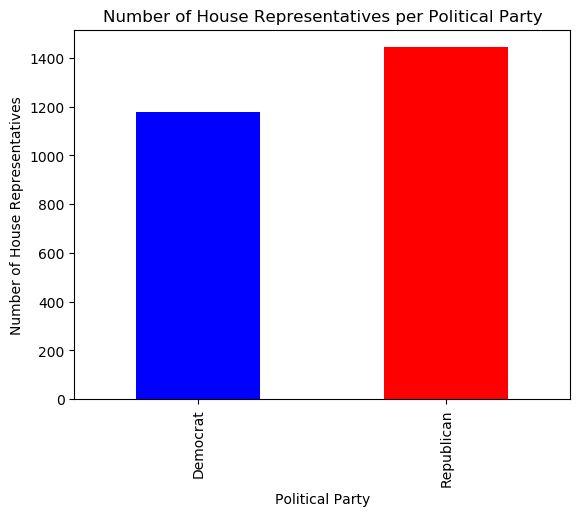

In [58]:
party_counts = merged_df['group'].value_counts()

party_counts.sort_index(inplace=True)

# Create a dictionary to specify the colors for each party
color_dict = {'Democrat': 'blue', 'Republican': 'red'}

# Create a bar chart using the party_counts and color dictionary
party_counts.plot(kind='bar', color=[color_dict.get(x) for x in party_counts.index])

# Set the title and labels for the bar chart
plt.title('Number of House Representatives per Political Party')
plt.xlabel('Political Party')
plt.ylabel('Number of House Representatives')

# Display the bar chart
plt.show()

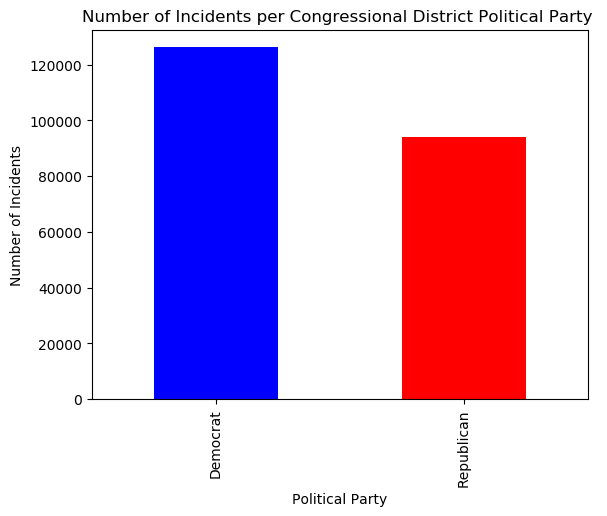

In [59]:
# Setting up a bar chart to show the amount of incident ids
# per political party
grouped_data = df.groupby('group')['incident_id'].count()

grouped_data.sort_index(inplace = True)

color_dict = {'Democrat': 'blue', 'Republican': 'red'}
grouped_data.plot(kind='bar', color=[color_dict.get(x) for x in grouped_data.index])

# Set the title and labels for the bar chart
plt.title('Number of Incidents per Congressional District Political Party ')
plt.xlabel('Political Party')
plt.ylabel('Number of Incidents')

# Display the bar chart
plt.show()

In [60]:
# One hot encoding the "group" variable to cast "democrat" and "republican" 
# into boolean variables to use in the model. 
encoded_group = pd.get_dummies(df['group'], prefix='group')

df = pd.concat([df.drop('group', axis=1), encoded_group], axis=1)
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_type,sources,state_house_district,state_senate_district,target_class,n_total,region,year,group_Democrat,group_Republican
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1,4,Middle Atlantic,2013,1,0
1,481268,2013-10-21,Pennsylvania,Pittsburgh (Homewood),7200 block of Kelly Street,2,5,http://www.gunviolencearchive.org/incident/481268,http://www.wtae.com/news/local/allegheny/two-p...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/10/20/home...,NaN,NaN,1,7,Middle Atlantic,2013,1,0
2,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1,4,Pacific,2013,1,0
3,486109,2013-05-10,California,Los Angeles,1600 block of West 205th Street,3,1,http://www.gunviolencearchive.org/incident/486109,http://articles.latimes.com/2013/may/10/local/...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://ktla.com/2013/05/10/police-3-dead-in-sh...,64.0,35.0,1,4,Pacific,2013,1,0
4,492950,2013-11-03,California,Los Angeles,1 World Way,1,3,http://www.gunviolencearchive.org/incident/492950,https://www.lawa.org/uploadedFiles/LAX/LAWA%20...,False,...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://www.nbclosangeles.com/news/local/SoCal-...,62.0,26.0,1,4,Pacific,2013,1,0


## Suspect Age

Significant Proportion Of Suspect Age Fell In 25-35 Age Range With The Ages Skewing Towards Younger Ages

              109067
Adult 18+     102980
Teen 12-17      7822
Child 0-11       477
Name: suspect_age, dtype: int64


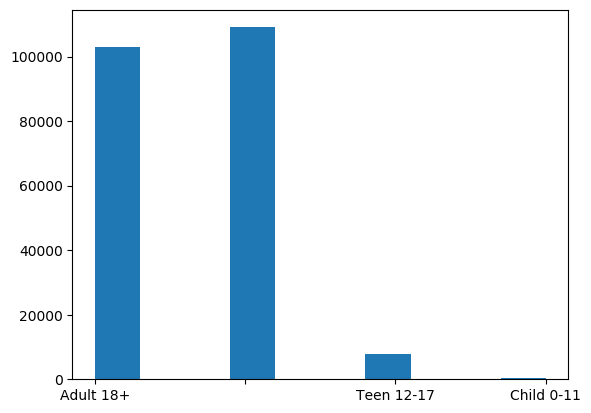

In [61]:
"""
New Suspect Age Group Column
Most suspects are adults 18+ category which doesn't tell us much, so the next column to create
is the actual age of the suspect (see next block in this notebook)
"""
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

df['suspect_age'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age_group']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        df.at[i, 'suspect_age'] = element[0]
                    else:
                        df.at[i, 'suspect_age'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


print(df['suspect_age'].value_counts())
plt.clf()
plt.hist(df['suspect_age'])
plt.show()

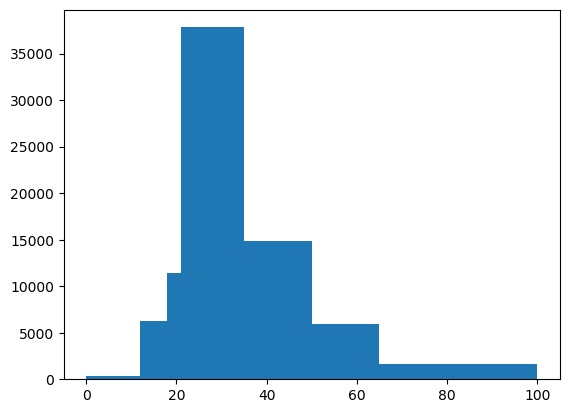

In [62]:
""""
Parse 'participant_type' and 'participant_age' column to get the suspect's actual age
"""
df['suspect_age_value'] = ''
df[['suspect_age_value']] = df[['suspect_age_value']].apply(pd.to_numeric)

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            pass
                            #print("empty element: --%s--" % element[0])
                        else:
                            df.at[i, 'suspect_age_value'] = int(element[0])
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            df.at[i, 'suspect_age_value'] = int(match_age[0])
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_age_value'].value_counts())
plt.clf()
#df = df.dropna(subset=['suspect_age_value'])
#print(type(df_temp.iloc[0]['suspect_age_value']))
#df_temp['suspect_age_value'] = df_temp['suspect_age_value'].apply(int)
#print("dataframe size: %d" % len(df))
plt.hist(df['suspect_age_value'], bins=[0,12,18,21,35,50,65,100])
plt.show()

## Incident Characteristics

Most Frequent Incident Characteristics For Incidents With 1 or more Injured or Killed

<Figure size 640x480 with 0 Axes>

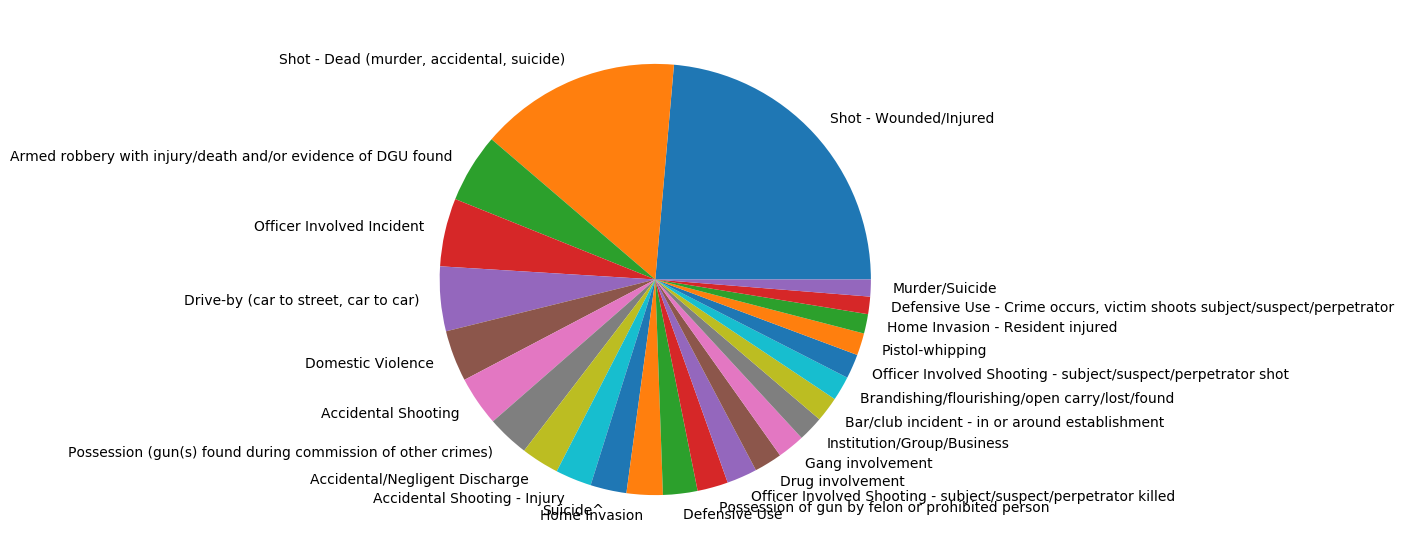

In [63]:
from collections import Counter

phrases_list = []
count = 0

for i, row in df.iterrows():

    if (row['n_injured'] >= 1 or row['n_killed'] >= 1):
        count = count + 1

        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']

            if '||' in str(incident_text):
                item = str(incident_text).split('||')

                for phrases in item:
                    phrases_list.append(phrases)

most_common_words_20 = Counter(phrases_list).most_common(25)
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c / len(counts))

plt.clf()
fig = plt.figure(figsize=(10, 7))
plt.pie(temp, labels=words)
plt.show()


Most Frequent Incident Characteristics Recorded for Gun Violence Incidents Where 0 People Were Injured And 0 People Were Killed

Number of incidents where injured = 0 and killed = 0: 88789
Total rows in dataframe: 220346
Percentage of none injured and none killed: 0.402953


<Figure size 640x480 with 0 Axes>

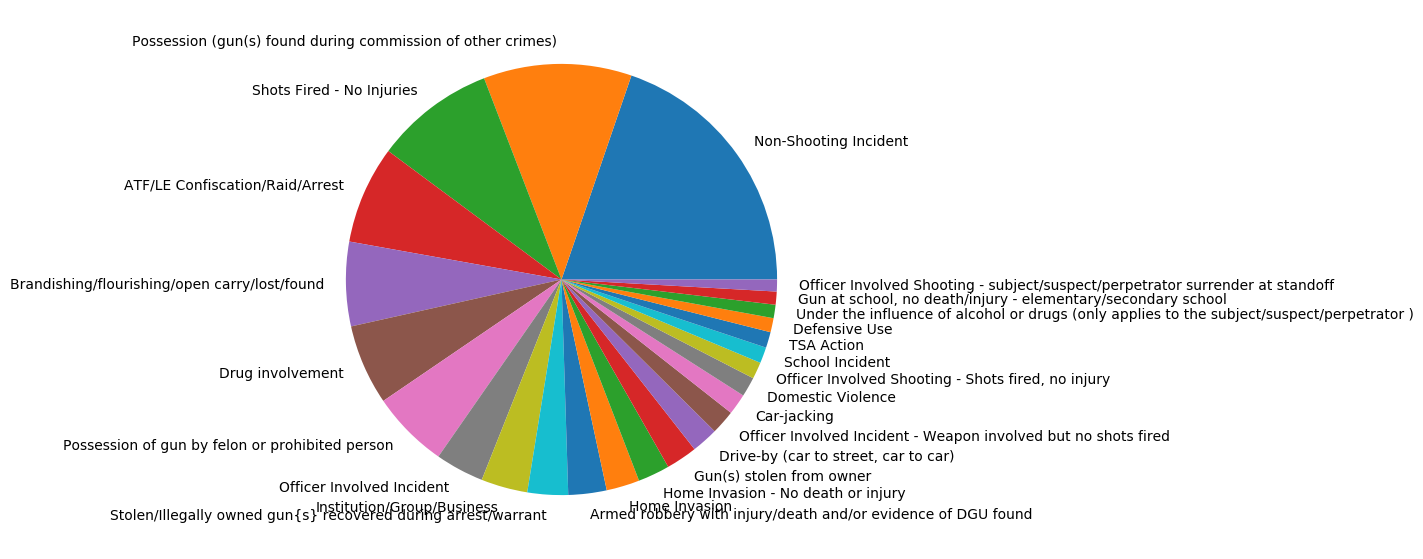

In [64]:
phrases_list = []
count = 0

for i, row in df.iterrows():
    if (row['n_injured'] == 0 and row['n_killed'] == 0):
        count = count + 1
        #print(row['incident_characteristics'])
 
        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']
            
            if '||' in str(incident_text):
                item = str(incident_text).split('||')
                
                for phrases in item:
                    phrases_list.append(phrases)


print("Number of incidents where injured = 0 and killed = 0: %d" % count)
print("Total rows in dataframe: %d" % len(df))
print("Percentage of none injured and none killed: %f" % (count/len(df)))


most_common_words_20 = Counter(phrases_list).most_common(25)
#print("\n\n25 Most Common Phrases in Incident Characteristics column:")
#for word, count in most_common_words_20:
#    print(f"{word}: {count}")

# Represent 20 Most Common Incident Characteristics as Pie Chart
# This is for the incidents where no one was injured or killed
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c/len(counts))
    
plt.clf()
fig = plt.figure(figsize =(10, 7))
plt.pie(temp, labels = words)
plt.show()

## Consistently High Percentage of Injuries or Deaths Associated With Certain Types Participant Relationships

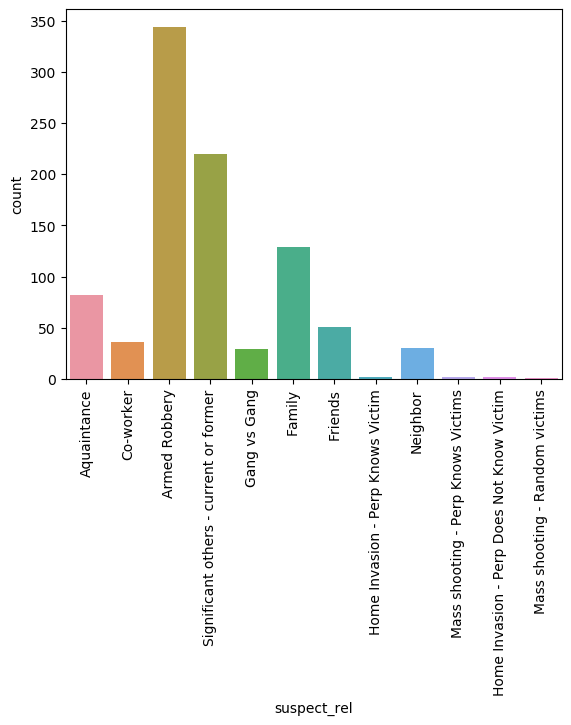

In [65]:
import seaborn as sns

df['suspect_rel'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)

    # get index number of suspect
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_relationship']
            if isinstance(row['participant_relationship'], float):
                pass
            else:
                regex = part_index + '::(.*)'
                #print("regex: %s" % regex)
                #print("temp_age_group: %s" % temp_age_group)
                if not isinstance(temp_age_group, float):
                    match_age = re.findall(regex, temp_age_group)
                    #print("match_age: %s" % match_age)
                    if len(match_age) != 0:
                        if '||' in match_age[0]:
                            element = match_age[0].split('||')
                            if element[0] == '':
                                pass
                                #print("empty element: --%s--" % element[0])
                            else:
                                df.at[i, 'suspect_rel'] = element[0]
                        else:
                            if match_age[0] == '':
                                #print("do nothing")
                                pass
                            else:
                                df.at[i, 'suspect_rel'] = match_age[0]
                            #print("i = %d" % i)
                    else:
                        continue

df_temp = df.dropna()
sns.countplot(x=df_temp['suspect_rel'], data =df_temp)
plt.xticks(rotation=90)
plt.show()

In [66]:
"""
For each type of relationship, get the percentage of incidents that resulted in 1 or more injuries or deaths
"""
rel_types = df_temp['suspect_rel'].value_counts().index

for i in rel_types:
    z = str(i)
    df_rel = df_temp.loc[df_temp['suspect_rel']==z]['n_injured']
    total = len(df_rel)

    df_rel_type = df_temp.loc[(df_temp['suspect_rel']==z) & ((df_temp['n_injured']>0) | (df_temp['n_killed']>0))]
    print("%s: %f" % (z,len(df_rel_type)/total))

Armed Robbery: 0.848837
Significant others - current or former: 0.881818
Family: 0.914729
Aquaintance: 0.914634
Friends: 1.000000
Co-worker: 0.861111
Neighbor: 0.666667
Gang vs Gang: 0.793103
Home Invasion - Perp Knows Victim: 1.000000
Mass shooting - Perp Knows Victims: 1.000000
Home Invasion - Perp Does Not Know Victim: 1.000000
Mass shooting - Random victims: 1.000000


# Impute for Null Values

## Number of Guns Involved ('n_guns_involved')

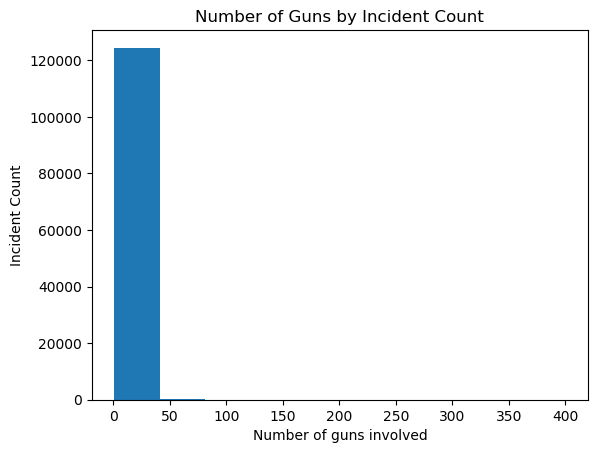

In [67]:
plt.hist(df['n_guns_involved'])
plt.xlabel("Number of guns involved")
plt.ylabel("Incident Count")
plt.title("Number of Guns by Incident Count")

plt.show()

### 

In [68]:
guns_inv=(df['n_guns_involved'].value_counts())/(len(df.index))
guns_inv

1.0      0.513733
2.0      0.030475
3.0      0.008305
4.0      0.003622
5.0      0.001725
           ...   
90.0     0.000005
53.0     0.000005
323.0    0.000005
103.0    0.000005
67.0     0.000005
Name: n_guns_involved, Length: 105, dtype: float64

In [69]:
df['n_guns_involved'].describe()

count    124609.000000
mean          1.383022
std           4.898754
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         400.000000
Name: n_guns_involved, dtype: float64

The number of guns involved is heavily right skewed, with the highest number of >400, while most incidents involve <50 guns. Closer inspection shows that over half of all incidents involve 1 gun (53.2%) The mean and mode for the number of guns involved is both 1. Thus, we will impute 1 for all null values in 'n_guns_involved'. 

In [70]:
df['n_guns_involved'].fillna(value=1, inplace=True)

## Latitude/Longitude

In [71]:
# Merge gun_violence and cities datasets on city and state columns
merged_cities= pd.merge(df, df_cities,left_on=['city_or_county', 'state'], right_on=['city', 'state_name'],  how='left')

# Update missing latitude and longitude values
df['latitude'].fillna(merged_cities['lat'], inplace=True)
df['longitude'].fillna(merged_cities['lng'], inplace=True)

## Suspect Age and Suspect Age Group

In [72]:
# Impute Suspect Age and Suspect Age Group
df['suspect_age_value'].fillna(df['suspect_age_value'].mean(), inplace=True)

In [73]:
# Bin the suspect age into custom age groups - provides more granularity than the original dataset's age group column
labels=['Child','Teen', 'Young Adult', 'Mid-Adult', 'Adult', 'Senior']
df['suspect_age_group']  = pd.cut(df['suspect_age_value'], bins=[1,12,18,25,35,65,200],labels=labels)

## Confirm imputations 

In [74]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         15070
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        405
incident_url_fields_missing         0
congressional_district              0
gun_stolen                      95755
gun_type                        95737
incident_characteristics          316
latitude                            2
location_description           181457
longitude                           2
n_guns_involved                     0
notes                           72969
participant_age                 84724
participant_age_group           37902
participant_gender              32377
participant_name               112979
participant_relationship       205935
participant_status              24517
participant_type                22004
sources     

In [75]:
df.shape

(220346, 39)

# Generate new CSV files

## CSV files will be generated for 
    1) Exploratory Data Analysis: includes original gun_violence dataset and all newly created features
    2) Modeling: includes only attributes selected for modeling and encoded dummy variables for categorical features


In [76]:
## Generate new CSV to include all feature creations to be used for EDA

import s3fs

s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://{}/EDA/data_for_eda.csv'.format(bucket),'w') as f:
    df.to_csv(f)
    
## Store dataframe to be used in other notebooks
%store df

Stored 'df' (DataFrame)


## Creating dummy variables for categorical variables

In [77]:
df['ohe_drug'] = 0
df['ohe_officer'] = 0
df['ohe_gang'] = 0
df['ohe_accident'] = 0
df['ohe_murder'] = 0
df['ohe_suicide'] = 0
df['ohe_arrest'] = 0
df['ohe_brandishing'] = 0
df['ohe_felon'] = 0
df['ohe_drive'] = 0
df['ohe_home_invasion'] = 0
df['ohe_stolen'] = 0
df['ohe_misc'] = 0
df['ohe_drugs'] = 0
df['ohe_car_jacking'] = 0
df['ohe_defensive'] = 0
df['ohe_robbery'] = 0
df['ohe_family'] = 0
df['ohe_institution'] = 0
df['ohe_accident'] = 0
df['ohe_child'] = 0
df['ohe_mass'] = 0
df['ohe_domestic'] = 0

# go through each incident in dataset
for i, row in df.iterrows():

    count = count + 1

    # if not null value
    if not isinstance(row['incident_characteristics'], float):
        # get the incident_characteristics column
        incident_text = row['incident_characteristics']

        # split by double bar to get the phrase
        if '||' in str(incident_text):
            item = str(incident_text).split('||')

            # in each phrase, check for keyword (ohe keyword)
            for phrase in item:
                phrase = phrase.lower()
                #phrases_list.append(phrases)
                if 'drug' in phrase:  # no caps sensitivity?
                    df.at[i, 'ohe_drugs'] = 1
                if 'officer' in phrase:
                    df.at[i, 'ohe_officer'] = 1
                if 'gang' in phrase:
                    df.at[i, 'ohe_gang'] = 1
                if 'DGU' in phrase:
                    df.at[i, 'ohe_defensive'] = 1
                if 'accident' in phrase:
                    df.at[i, 'ohe_accident'] = 1
                if 'defensive' in phrase:
                    df.at[i, 'ohe_defensive'] = 1
                if 'murder' in phrase:
                    df.at[i, 'ohe_murder'] = 1
                if 'home' in phrase:
                    df.at[i, 'ohe_home_invasion'] = 1
                if 'suicide' in phrase:
                    df.at[i, 'ohe_suicide'] = 1
                if 'arrest' in phrase:
                    df.at[i, 'ohe_arrest'] = 1
                if 'officer' in phrase:
                    df.at[i, 'ohe_officer'] = 1
                if 'brandishing' in phrase:
                    df.at[i, 'ohe_brandishing'] = 1
                if 'felon' in phrase:
                    df.at[i, 'ohe_felon'] = 1
                if 'drive' in phrase:
                    df.at[i, 'ohe_drive'] = 1
                if 'home' in phrase:
                    df.at[i, 'ohe_home_invasion'] = 1
                if 'car' in phrase:
                    df.at[i, 'ohe_car_jacking'] = 1
                if 'stolen' in phrase:
                    df.at[i, 'ohe_stolen'] = 1
                if 'robbery' in phrase:
                    df.at[i, 'ohe_robbery'] = 1
                if 'family' in phrase:
                    df.at[i, 'ohe_family'] = 1
                if 'institution' in phrase:
                    df.at[i, 'ohe_institution'] = 1
                if 'domestic' in phrase:
                    df.at[i, 'ohe_domestic'] = 1
                if 'accident' in phrase:
                    df.at[i, 'ohe_accident'] = 1
                if 'child' in phrase:
                    df.at[i, 'ohe_child'] = 1
                if 'mass' in phrase:
                    df.at[i, 'ohe_mass'] = 1
                else:
                    df.at[i, 'ohe_misc'] = 1

In [78]:
df = pd.get_dummies(df, columns=['suspect_age_group'], drop_first=True)

In [79]:
df = pd.get_dummies(df, columns=['region'], drop_first=True)

In [80]:
df_select=df.drop(columns=[
    'incident_id',
    'date',
    'state',
    'city_or_county',
    'address',
    'n_killed',
    'n_injured',
    'incident_url',
    'source_url',
    'incident_url_fields_missing',
    'congressional_district',
   'gun_stolen',
    'gun_type',
    'incident_characteristics',
    'location_description',
    'notes',
    'participant_age',
    'participant_age_group',
    'participant_gender',
    'participant_name',
    'participant_relationship',
    'participant_status',
    'participant_type',
    'sources',
    'state_house_district',
    'state_senate_district',
    'year',
    'group_Republican',
    'suspect_age_value',
    'suspect_rel',
    'n_total'])

In [81]:
df_select

,latitude,longitude,n_guns_involved,target_class,group_Democrat,suspect_age,ohe_drug,ohe_officer,ohe_gang,ohe_accident,...,suspect_age_group_Adult,suspect_age_group_Senior,region_East South Central,region_Middle Atlantic,region_Mountain,region_New England,region_Pacific,region_South Atlantic,region_West North Central,region_West South Central
0,40.3467,-79.8559,1.0,1,1,Adult 18+,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,40.4555,-79.8970,1.0,1,1,,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,33.9090,-118.3330,1.0,1,1,,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,33.8447,-118.3070,1.0,1,1,Adult 18+,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,33.9454,-118.3990,1.0,1,1,,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220341,40.0979,-74.4180,1.0,1,0,,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
220342,40.0792,-74.2077,20.0,0,0,Adult 18+,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
220343,40.8475,-73.8311,1.0,0,1,,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
220344,40.7467,-73.8611,1.0,0,1,Adult 18+,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [82]:
list(df_select.columns)

['latitude',
 'longitude',
 'n_guns_involved',
 'target_class',
 'group_Democrat',
 'suspect_age',
 'ohe_drug',
 'ohe_officer',
 'ohe_gang',
 'ohe_accident',
 'ohe_murder',
 'ohe_suicide',
 'ohe_arrest',
 'ohe_brandishing',
 'ohe_felon',
 'ohe_drive',
 'ohe_home_invasion',
 'ohe_stolen',
 'ohe_misc',
 'ohe_drugs',
 'ohe_car_jacking',
 'ohe_defensive',
 'ohe_robbery',
 'ohe_family',
 'ohe_institution',
 'ohe_child',
 'ohe_mass',
 'ohe_domestic',
 'suspect_age_group_Teen',
 'suspect_age_group_Young Adult',
 'suspect_age_group_Mid-Adult',
 'suspect_age_group_Adult',
 'suspect_age_group_Senior',
 'region_East South Central',
 'region_Middle Atlantic',
 'region_Mountain',
 'region_New England',
 'region_Pacific',
 'region_South Atlantic',
 'region_West North Central',
 'region_West South Central']

In [83]:
## Generate new CSV file to be used for modeling

import s3fs

s3 = s3fs.S3FileSystem(anon=False)
"""
with s3.open('sagemaker-studio-458903497716-h2kl4ff3dz/modeling/data_for_modeling.csv','w') as f:
    df_select.to_csv(f)
"""
with s3.open('s3://{}/modeling/data_for_modeling.csv'.format(bucket),'w') as f:
    df_select.to_csv(f)

## Store dataframe to be used for modeling
%store df_select

Stored 'df_select' (DataFrame)
